In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from time import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes[0].plot(history['epoch'], history['train_loss'], label='train_loss')
    axes[0].plot(history['epoch'], history['val_loss'], label='val_loss')
    axes[1].plot(history['epoch'], history['val_score'], label='val_score')
    for i in [0,1]: axes[i].legend()
def iou_pytorch(pred, target):
    """
    Рассчитывает Intersection over Union (IoU) для двух бинарных тензоров.

    Args:
        pred (torch.Tensor): Предсказанный бинарный тензор (0 или 1).
        target (torch.Tensor): Целевой бинарный тензор (0 или 1).

    Returns:
        float: Значение IOU.
    """
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    
    iou = float(intersection) / float(union)
    return iou

In [3]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, path):
        file_pairs = []
        x_folder_path = os.path.join(path, "X")
        y_folder_path = os.path.join(path, "Y")

        x_files = sorted(os.listdir(x_folder_path))
        y_files = sorted(os.listdir(y_folder_path))
        if len(x_files) != len(y_files):
            print("Количество файлов в папках X и Y не совпадает.")
        else:
            for x_file, y_file in zip(x_files, y_files):
                x_file_path = os.path.join(x_folder_path, x_file)
                y_file_path = os.path.join(y_folder_path, y_file)
                file_pairs.append((x_file_path, y_file_path))
        self.data = file_pairs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pair = self.data[idx]
        # print(pair[0], pair[1])
        x, y = self.custom_transform(pair[0], pair[1])
        return x, y

    def custom_transform(self, x, y):
        x = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
        x = transforms.ToTensor()(x)
        y = cv2.cvtColor(cv2.imread(y), cv2.COLOR_BGR2RGB)
        y = transforms.ToTensor()(y)
        condition = (y[0] == 1) & (y[1] == 1) & (y[2] == 1)
        y = torch.where(condition, torch.tensor(0), torch.tensor(1)).unsqueeze(0).to(torch.uint8)
        return x, y

In [5]:
dataset = CustomDataset("./XY")
batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

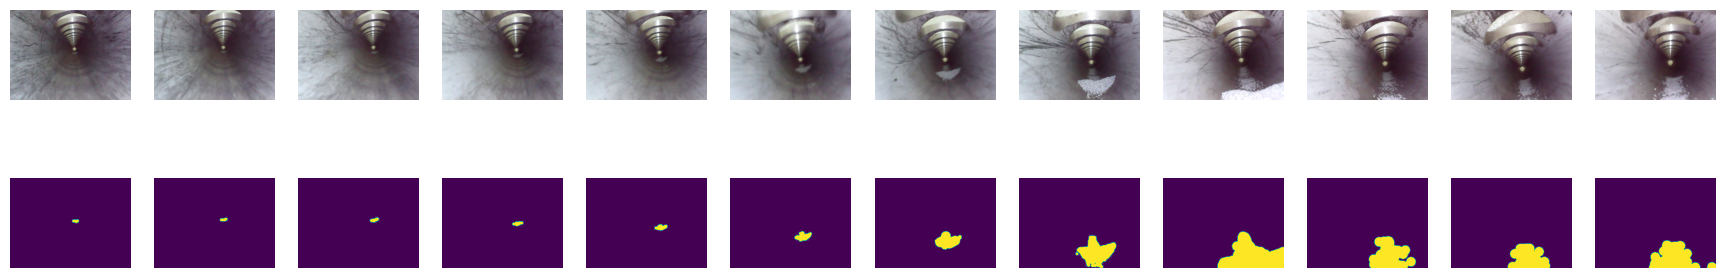

In [6]:
n = 12
plt.figure(figsize=(22, 4))
for i in range(n):
    x, y = dataset[i]
    x = np.transpose(x, (1, 2, 0))
    y = np.transpose(y, (1, 2, 0))
    plt.subplot(2, n, i+1)
    plt.axis("off")
    plt.imshow(x)

    plt.subplot(2, n, i+1+n)
    plt.axis("off")
    plt.imshow(y)
plt.show();

In [7]:
def train(model, opt, loss_fn, epochs, data_tr, epsilon):
    # history = {'epoch':[],'train_loss':[],'val_loss':[],'val_score':[]}
    # X_val, Y_val = next(iter(data_tr))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step() # update weights
  
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            print("OK")

        toc = time()
        print('loss: %f' % avg_loss)
        
        

        # show intermediate results
#         model.eval()
#         Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
#         Y_hat = (torch.sigmoid(Y_hat) > epsilon).int()
# #         Y_hat = torch.sigmoid(Y_hat)
#         val_score = iou_pytorch(Y_val, Y_hat).mean()
#         val_loss = loss_fn(Y_val, Y_hat)

#         history['epoch'].append(epoch)
#         history['train_loss'].append(avg_loss.item())
#         history['val_loss'].append(val_loss.item())
#         history['val_score'].append(val_score.item())
#         # Visualize tools
#         clear_output(wait=True)
#         for k in range(6):
#             plt.subplot(2, 6, k+1)
#             plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
#             plt.title('Real')
#             plt.axis('off')

#             plt.subplot(2, 6, k+7)
#             plt.imshow(Y_hat[k, 0], cmap='gray')
#             plt.title('Output')
#             plt.axis('off')
#         plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
#         plt.show()

#     plot_history(history)

In [8]:
def bce_loss(y_real, y_pred):
    return (y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

In [9]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True, progress=False).to(device)
max_epochs = 1000
optim = torch.optim.Adam(model.parameters(), lr=0.003)
train(model, optim, bce_loss, max_epochs, dataloader, 0.7)

* Epoch 1/1000


: 